In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
!conda install -c rdkit rdkit

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.78.0               |   py39h7c9e3ff_4         364 KB  conda-forge
    boost-cpp-1.78.0           |       h75c5d50_1        17.1 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    cairo-1.16.0               |    ha61ee94_1014         1.5 MB  conda-forge
    conda-23.1.0               |   py39hf3d152e_0         906 KB  conda-forge
    contourpy-1.0.7            |   py39h4b4f3f3_0     

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
#Generate Tautomers and remove salt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolStandardize
from rdkit.Chem.SaltRemover import SaltRemover

remover = SaltRemover()

# Open the input file
with open('smiles.smi', 'r') as infile:
    # Open the output file
    with open('final_smiles.smi', 'w') as outfile:
        # Loop through each line in the input file
        for line in infile:
            # Split the line into the name and SMILES string
            smiles, name = line.strip().split('\t')
            
            mol = Chem.MolFromSmiles(smiles)
            stripped_mol= remover.StripMol( mol ) 
            smiles_desalted=Chem.MolToSmiles(stripped_mol) 

            # Generate tautomers for the molecule using MolVS
            tautomers = MolStandardize.enumerate_tautomers_smiles(smiles_desalted) # Change the number of tautomers to generate
            # Write the original molecule and its tautomers to the output file
            outfile.write(name + '\t' + smiles_desalted + '\n')
            for i in range(0,len(tautomers)):
                outfile.write(name + '_tautomer_'+str(i+1)+'\t' + list(tautomers)[i] +  '\n')

In [4]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import matplotlib.pyplot as plt
import subprocess

Populating the interactive namespace from numpy and matplotlib


In [5]:
# File locations
sdfFilePath = 'output.sdf' # The input file of structures to generate conformations from
ConfoutputFilePath = 'conf_output.sdf' # Output file containing conformations for docking

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

42

In [6]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

In [7]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = 3

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
    # perform  minimization 
          AllChem.MMFFOptimizeMolecule(m, confId=id, mmffVariant='MMFF94s')
    # EmbedMultipleConfs returns a Boost-wrapped type which)
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name


writer = Chem.SDWriter(ConfoutputFilePath)


with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:14 |###############################|


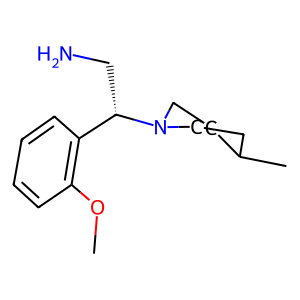

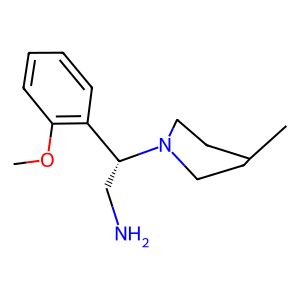

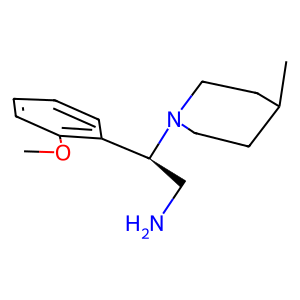

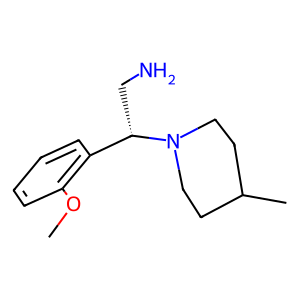

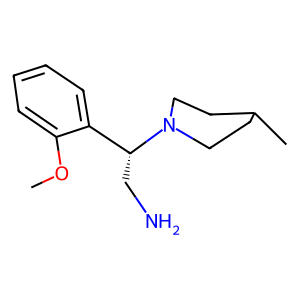

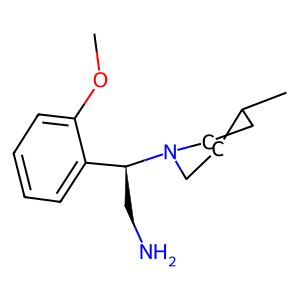

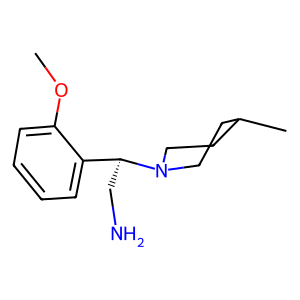

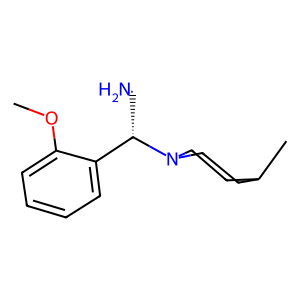

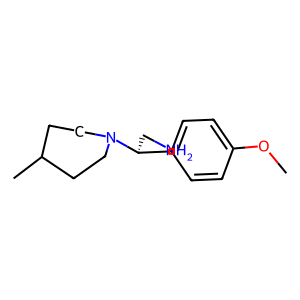

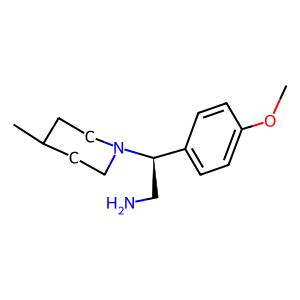

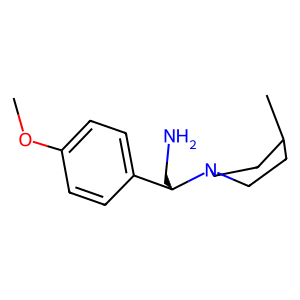

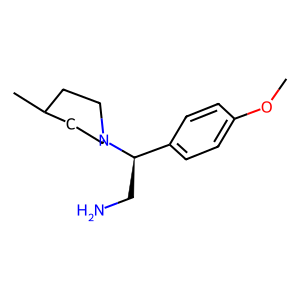

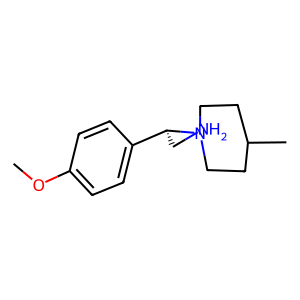

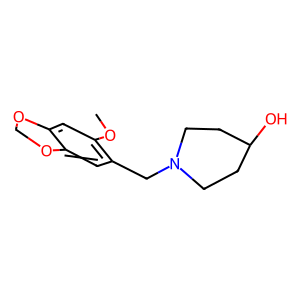

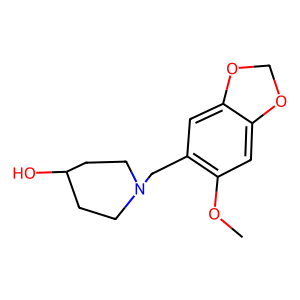

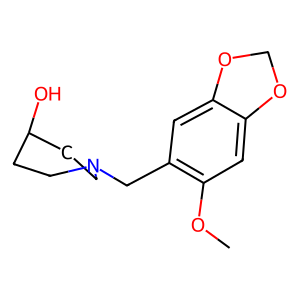

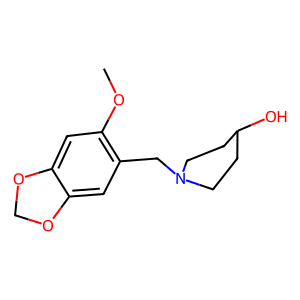

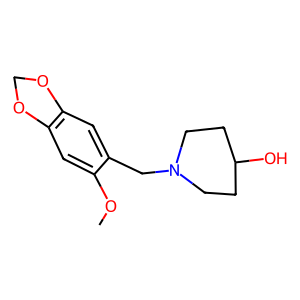

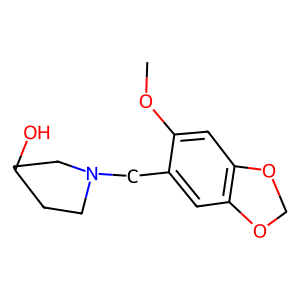

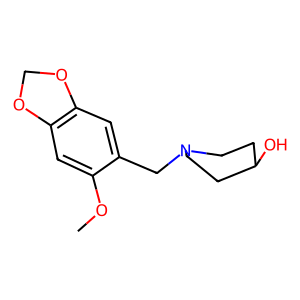

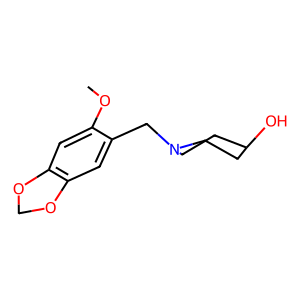

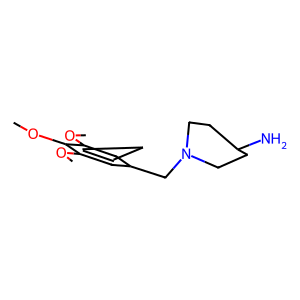

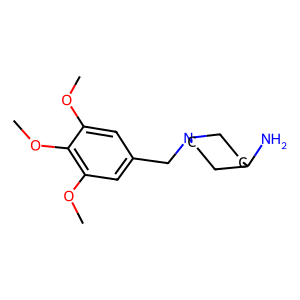

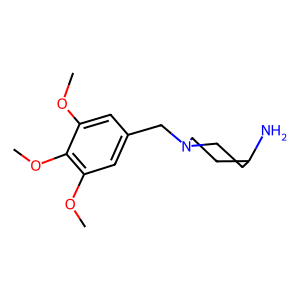

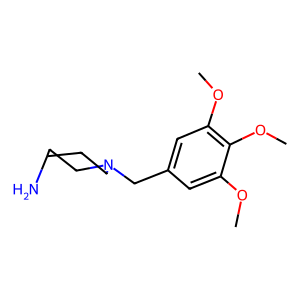

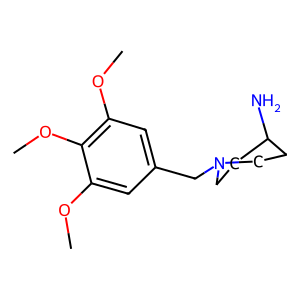

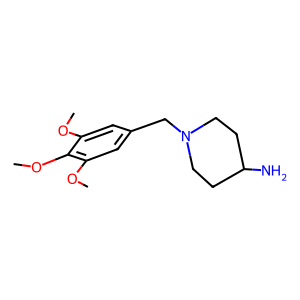

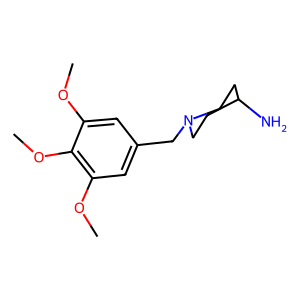

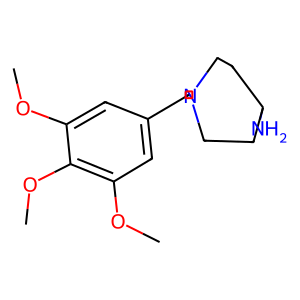

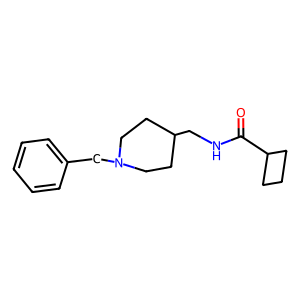

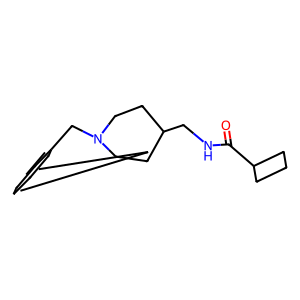

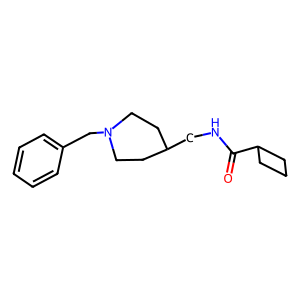

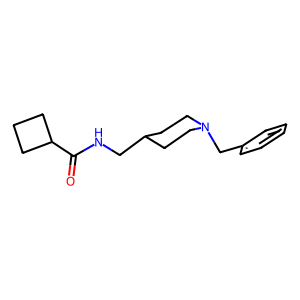

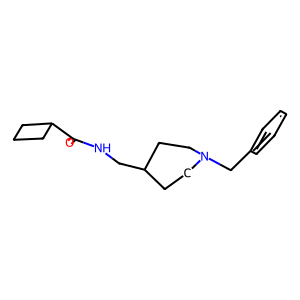

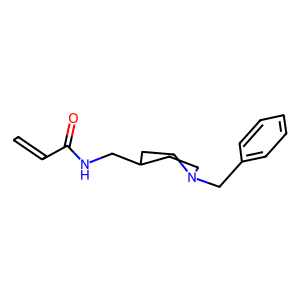

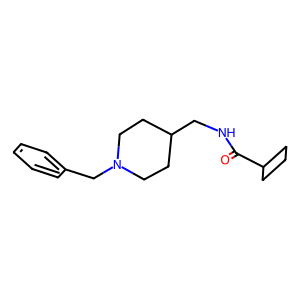

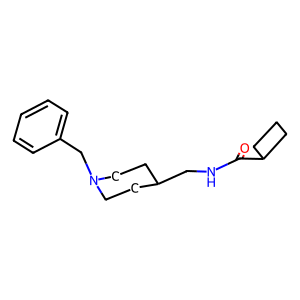

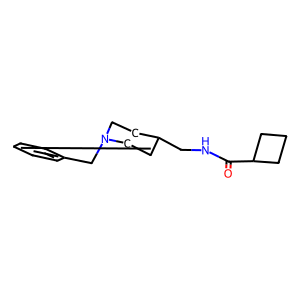

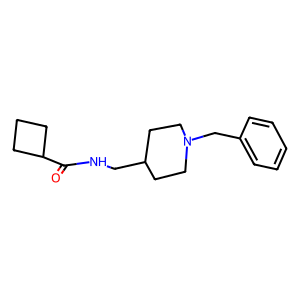

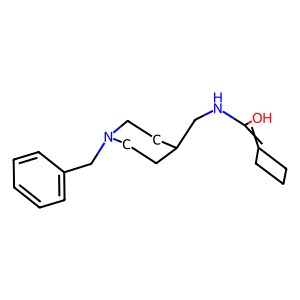

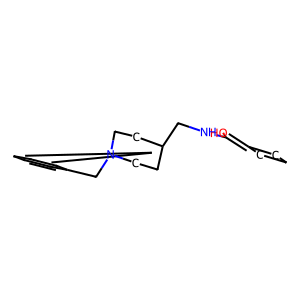

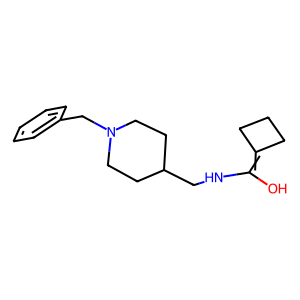

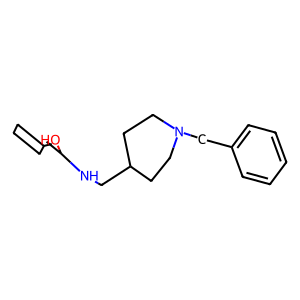

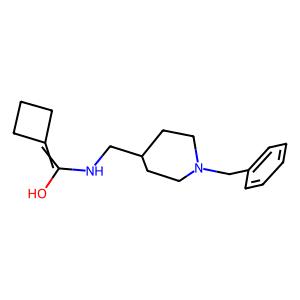

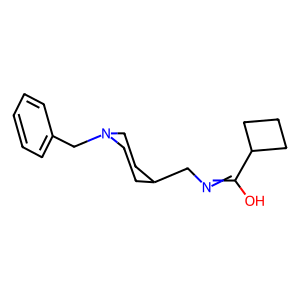

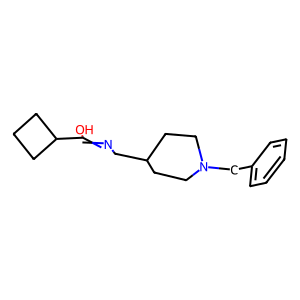

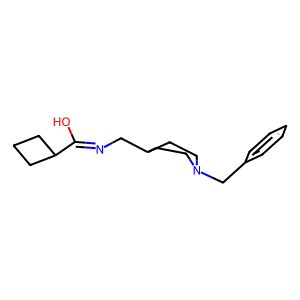

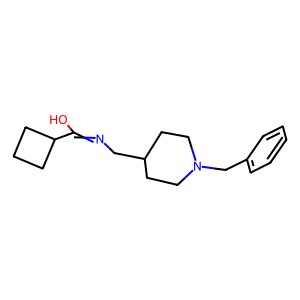

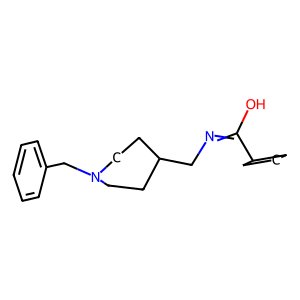

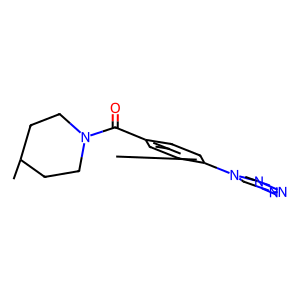

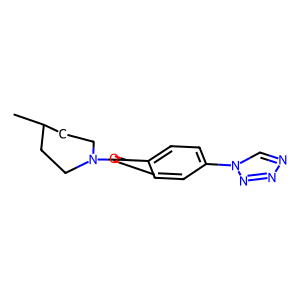

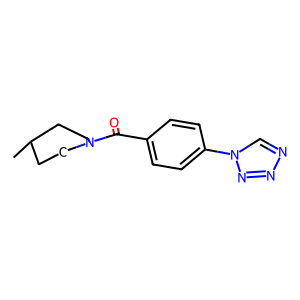

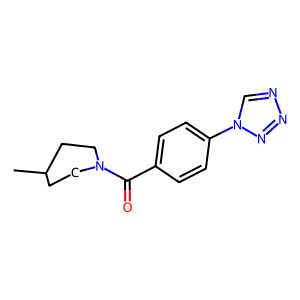

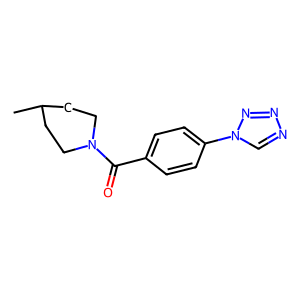

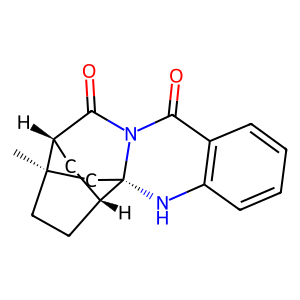

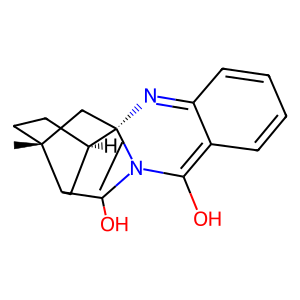

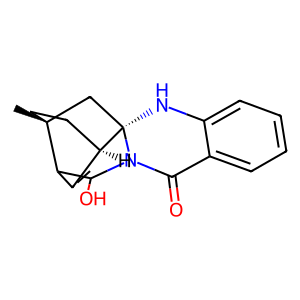

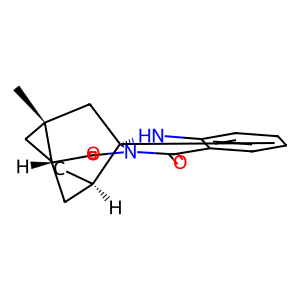

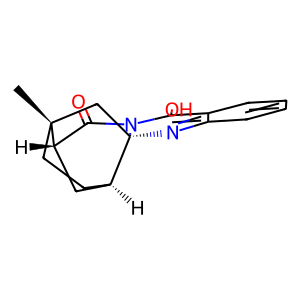

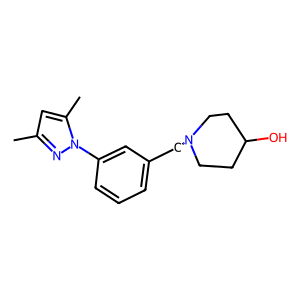

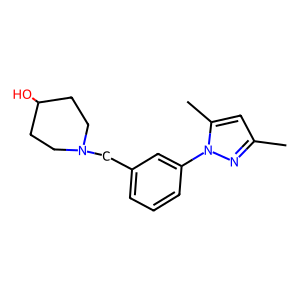

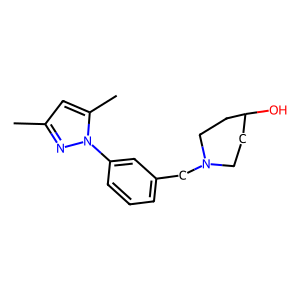

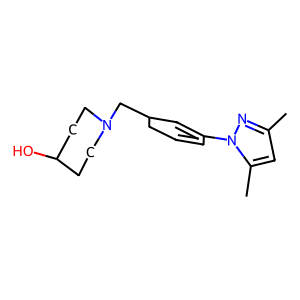

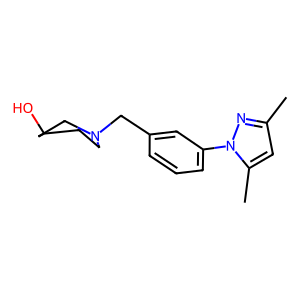

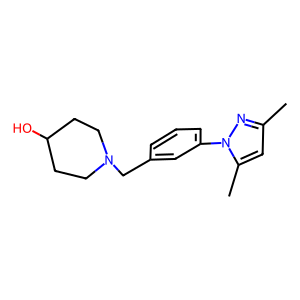

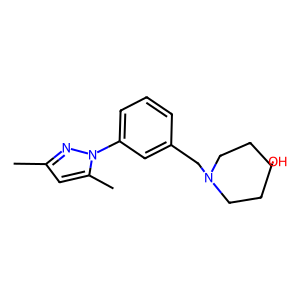

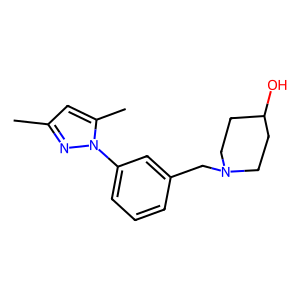

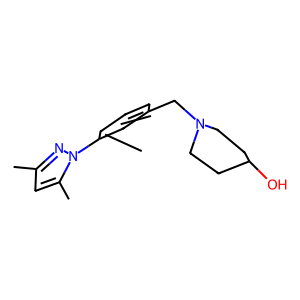

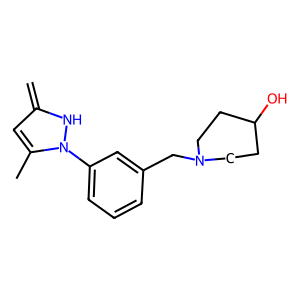

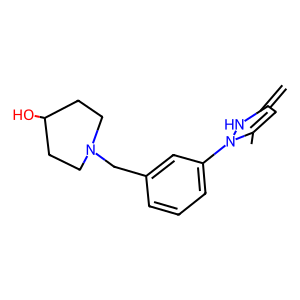

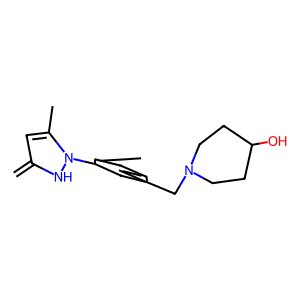

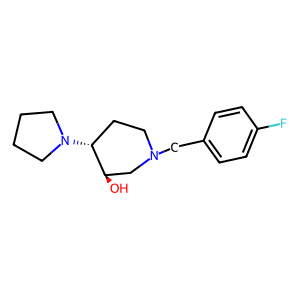

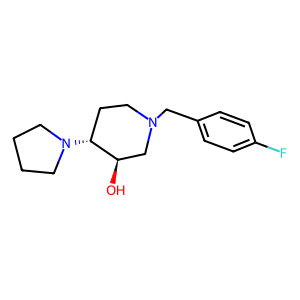

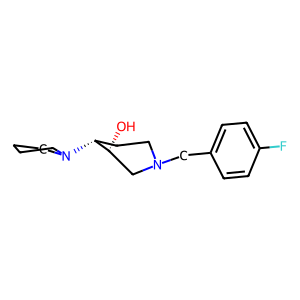

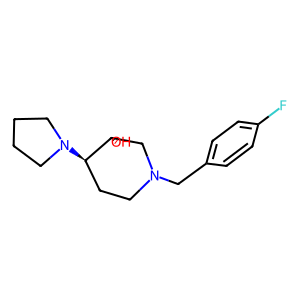

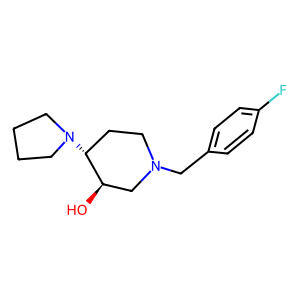

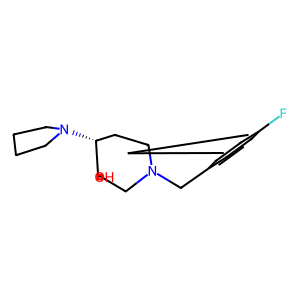

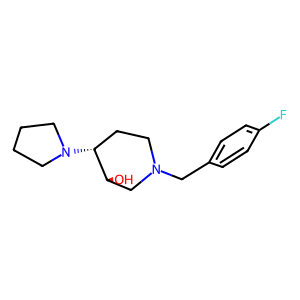

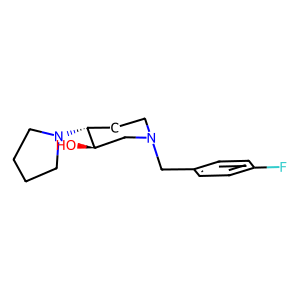

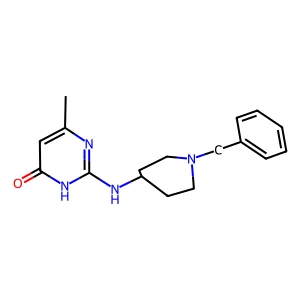

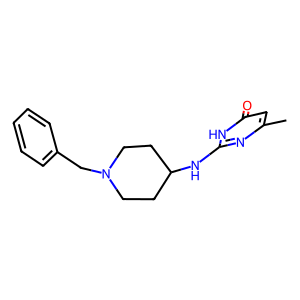

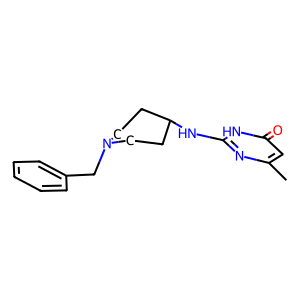

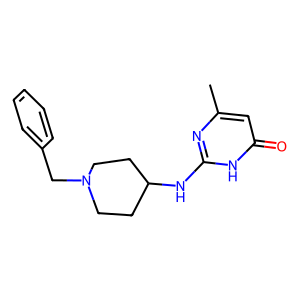

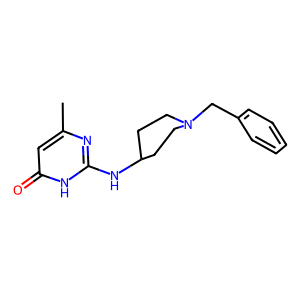

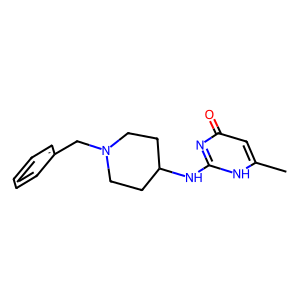

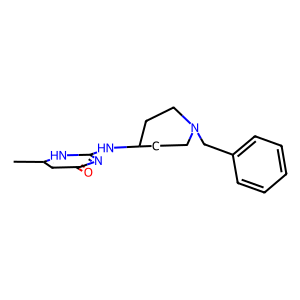

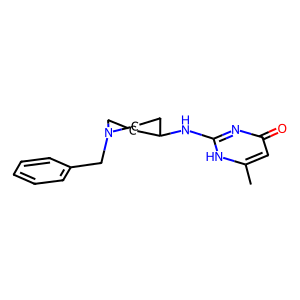

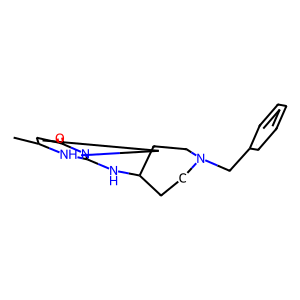

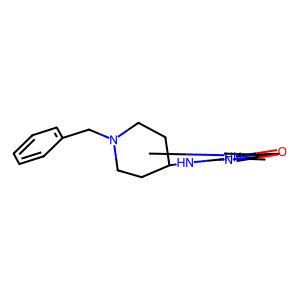

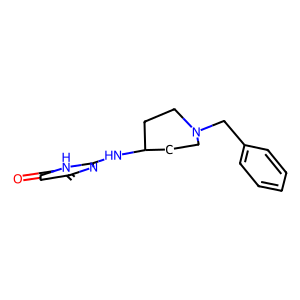

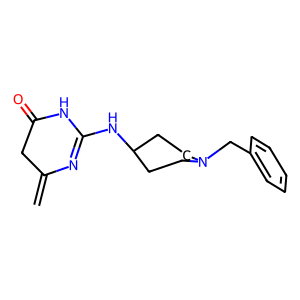

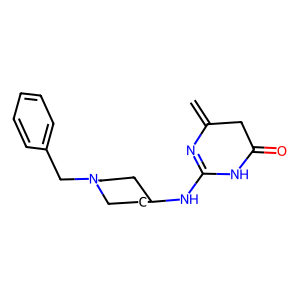

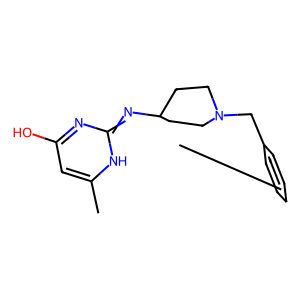

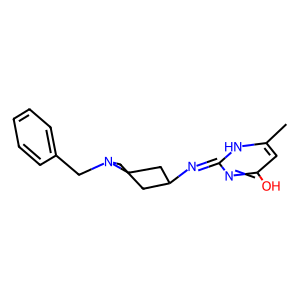

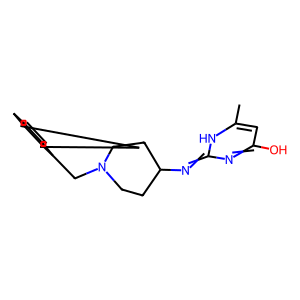

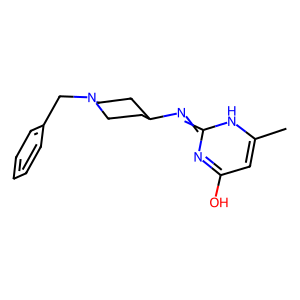

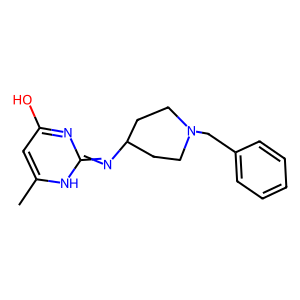

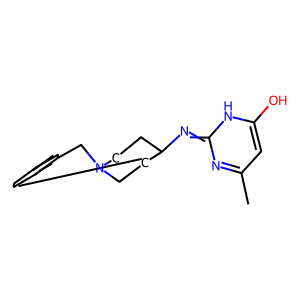

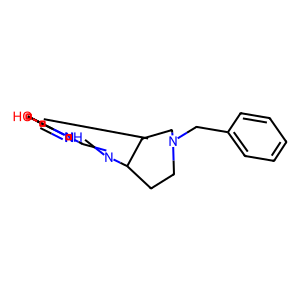

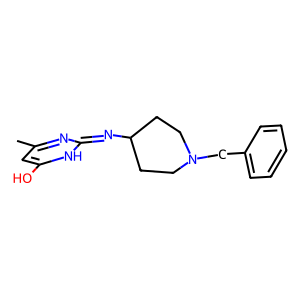

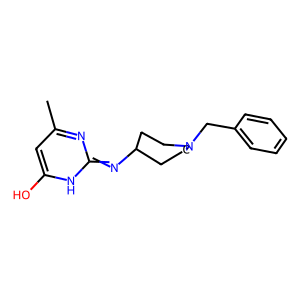

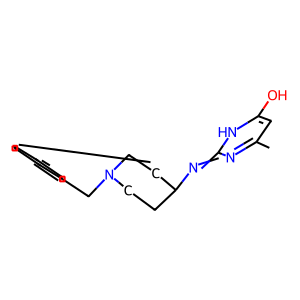

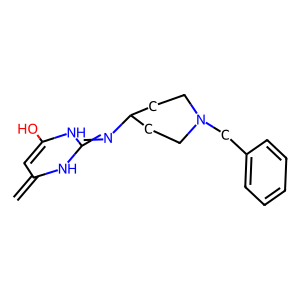

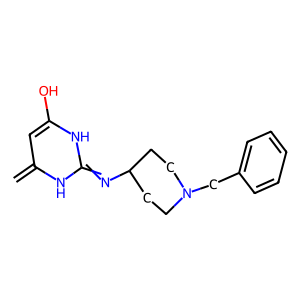

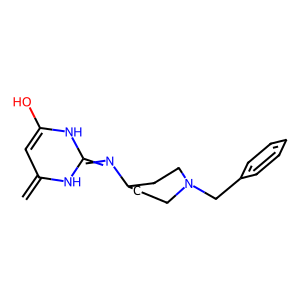

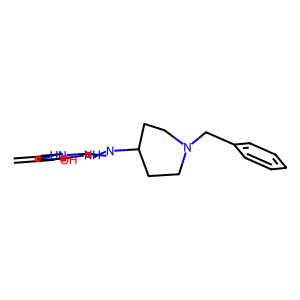

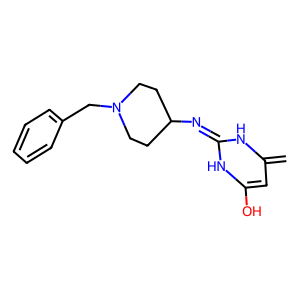

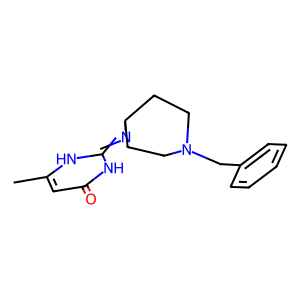

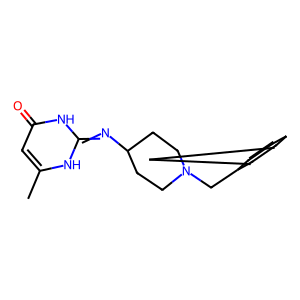

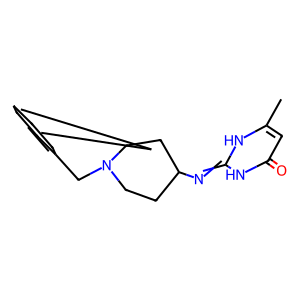

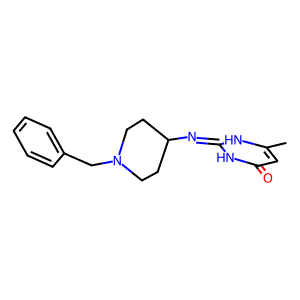

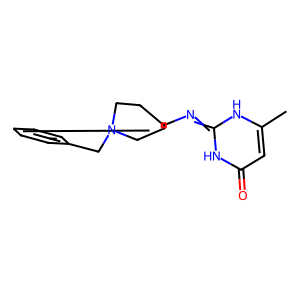

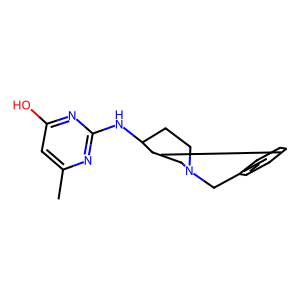

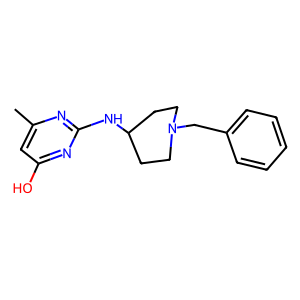

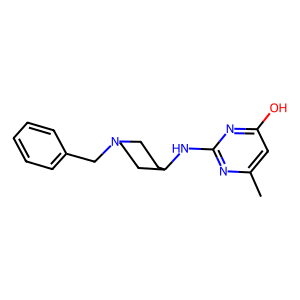

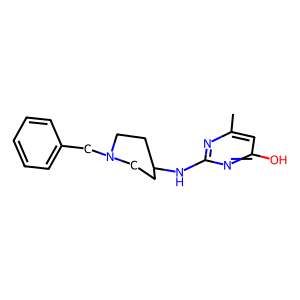

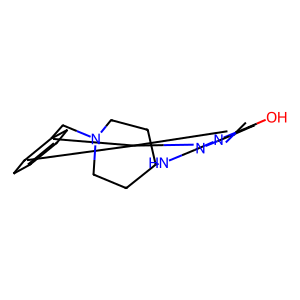

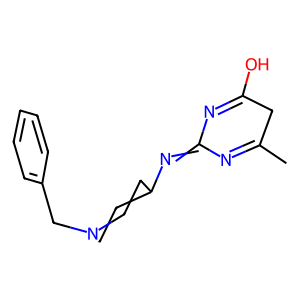

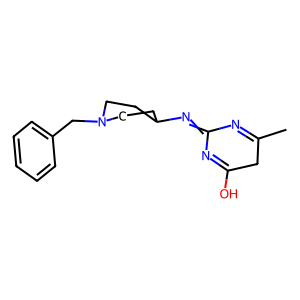

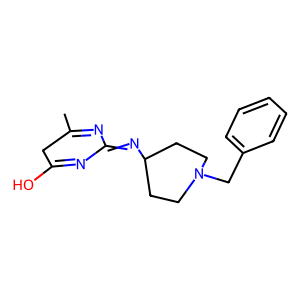

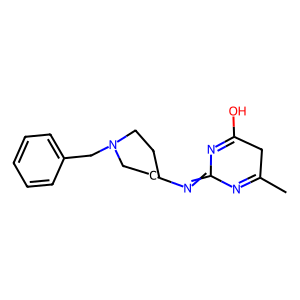

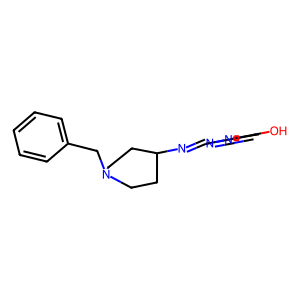

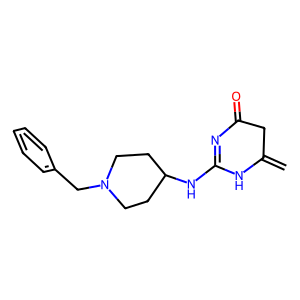

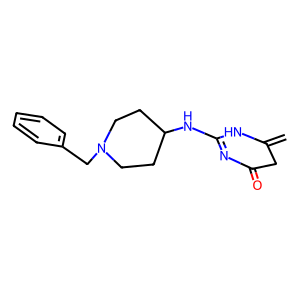

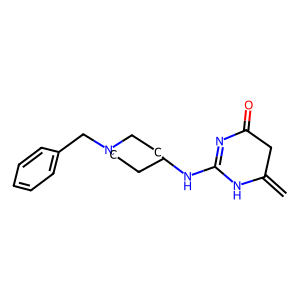

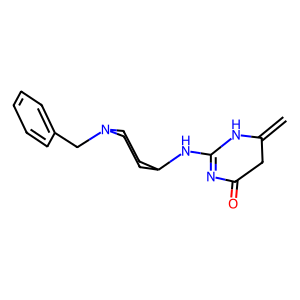

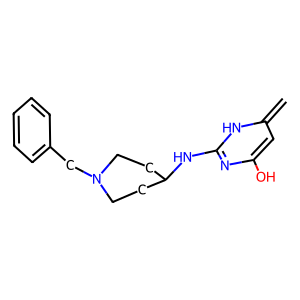

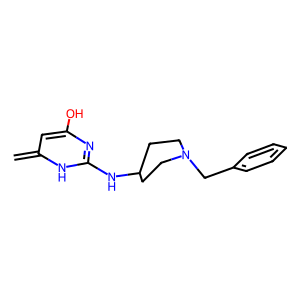

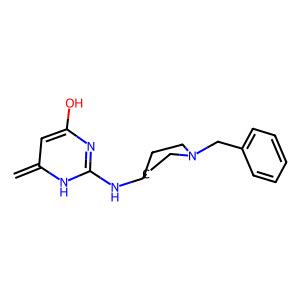

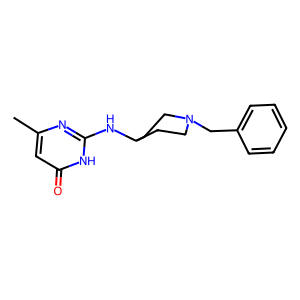

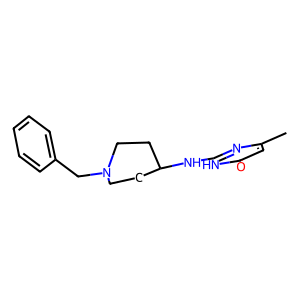

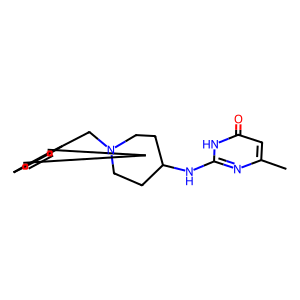

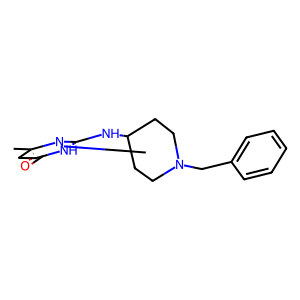

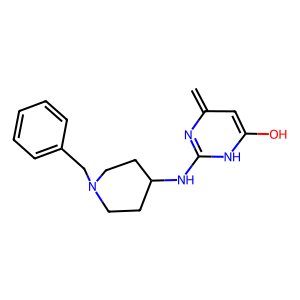

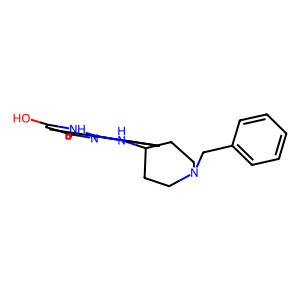

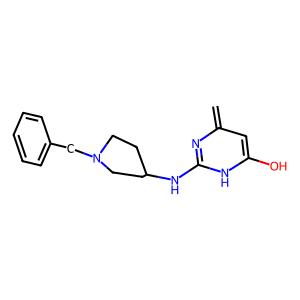

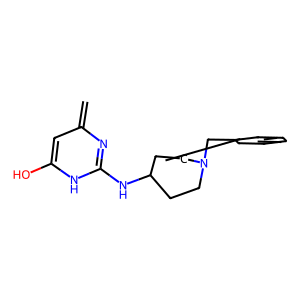

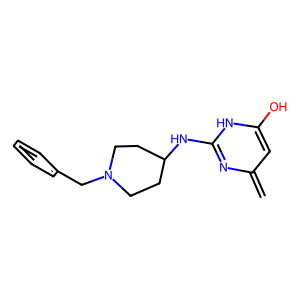

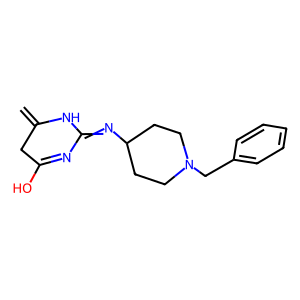

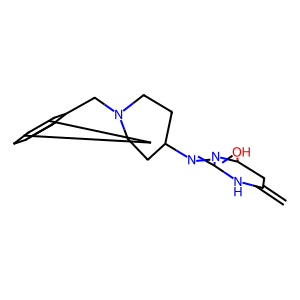

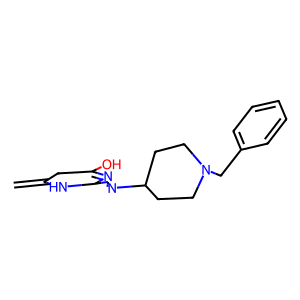

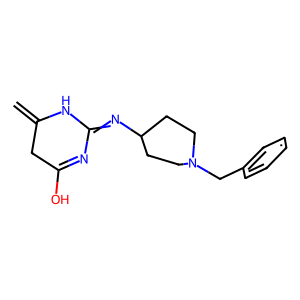

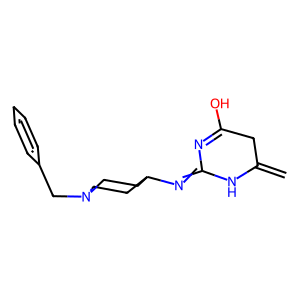

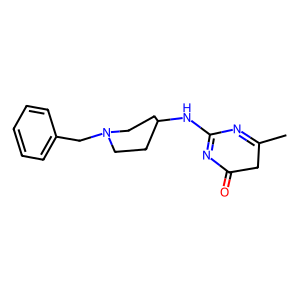

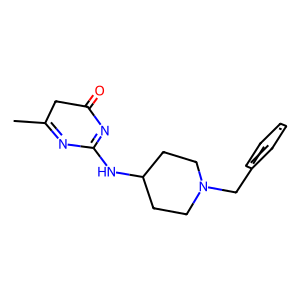

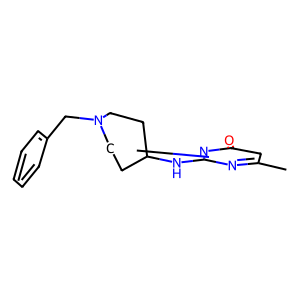

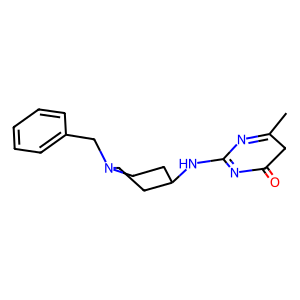

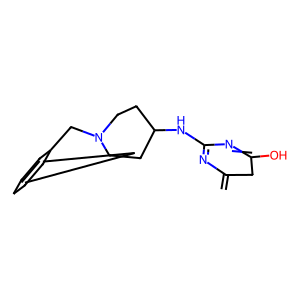

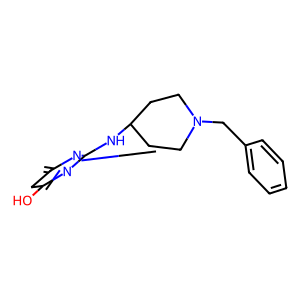

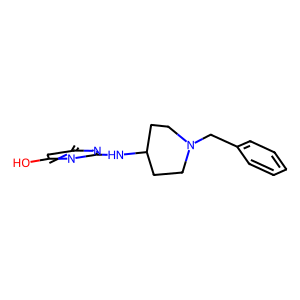

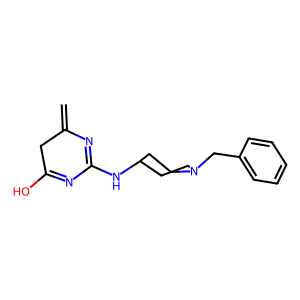

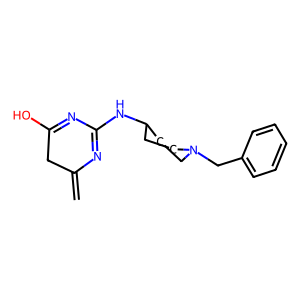

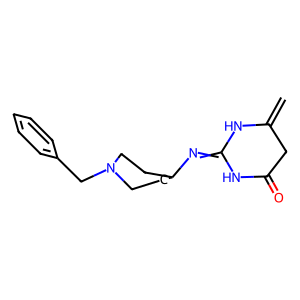

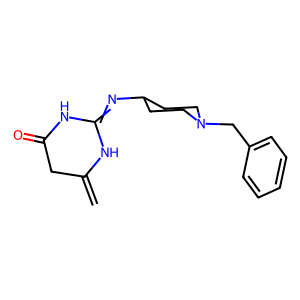

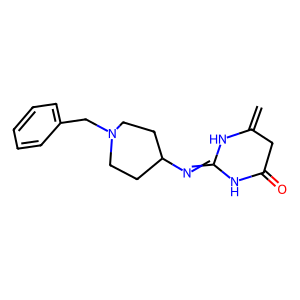

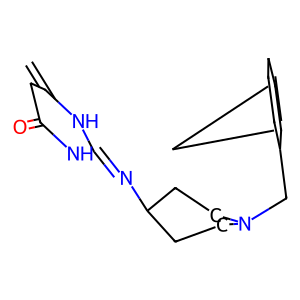

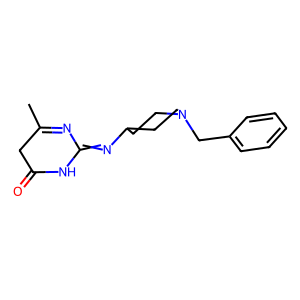

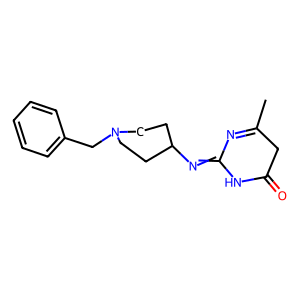

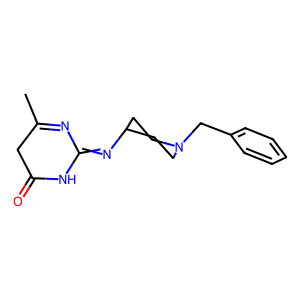

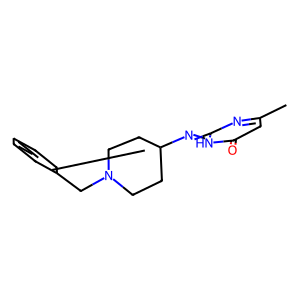

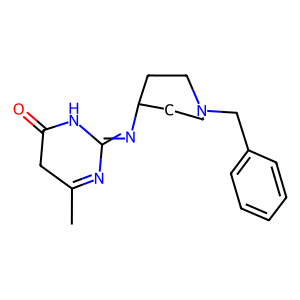

In [8]:
from rdkit.Chem import Draw

# Read the SDF file and create a supplier object
suppl = Chem.SDMolSupplier('conformers_output.sdf')

# Iterate through the molecules and visualize each conformer
for mol in suppl:
    if mol is not None:
        # Get the conformers
        conformers = mol.GetConformers()

        # Visualize each conformer
        for i in range(len(conformers)):
            mol_copy = Chem.Mol(mol)
            mol_copy.RemoveAllConformers()
            mol_copy.AddConformer(conformers[i], assignId=True)
            img = Draw.MolToImage(mol_copy)
            img.show()